# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

31.549965113831362

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

19.98972901481876

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

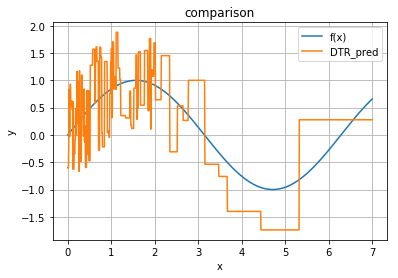

In [6]:
from sklearn.tree import DecisionTreeRegressor

x = np.random.exponential(size=sample_size)
y = f(x) + np.random.uniform(-1, 1, sample_size)
DT_reg = DecisionTreeRegressor()
DT_reg.fit(x[:, np.newaxis], y)
DT_pred = DT_reg.predict(linspace[:, np.newaxis])

plt.figure()
plt.plot(linspace, f(linspace), label="f(x)")
plt.plot(linspace, DT_pred, label="DTR_pred")
plt.title("comparison")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend(loc='best')
plt.show()

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

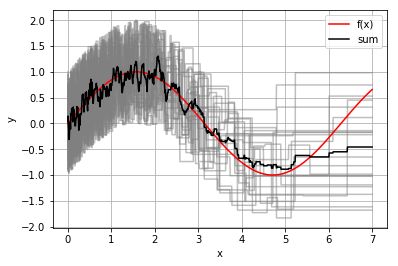

In [7]:
gen_DT_pred = []
for i in range(samples_num):
    x = np.random.exponential(size=sample_size)
    y = f(x) + np.random.uniform(-1, 1, sample_size)
    DT_reg = DecisionTreeRegressor()
    DT_reg.fit(x[:, np.newaxis], y)
    DT_pred = DT_reg.predict(linspace[:, np.newaxis])
    gen_DT_pred.append(DT_pred)
    plt.plot(linspace, DT_pred, color="gray", alpha=0.5)
plt.plot(linspace, f(linspace), label="f(x)", color="red")
plt.plot(linspace, sum(gen_DT_pred) / samples_num, label="sum", color="black")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend(loc='best')
plt.show()

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

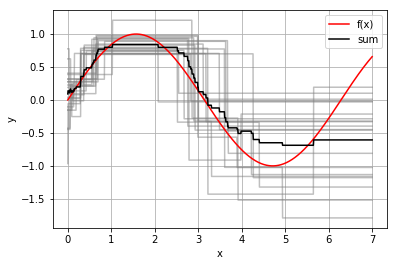

In [8]:
gen_DT_pred = []
for i in range(samples_num):
    x = np.random.exponential(size=sample_size)
    y = f(x) + np.random.uniform(-1, 1, sample_size)
    DT_reg = DecisionTreeRegressor(max_depth=2)
    DT_reg.fit(x[:, np.newaxis], y)
    DT_pred = DT_reg.predict(linspace[:, np.newaxis])
    gen_DT_pred.append(DT_pred)
    plt.plot(linspace, DT_pred, color="gray", alpha=0.5)
plt.plot(linspace, f(linspace), label="f(x)", color="red")
plt.plot(linspace, sum(gen_DT_pred) / samples_num, label="sum", color="black")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend(loc='best')
plt.show()

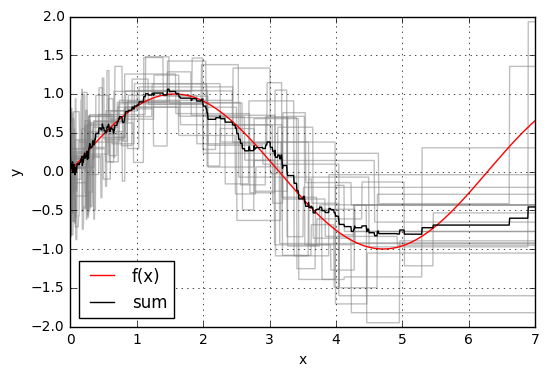

In [9]:
gen_DT_pred = []
for i in range(samples_num):
    x = np.random.exponential(size=sample_size)
    y = f(x) + np.random.uniform(-1, 1, sample_size)
    DT_reg = DecisionTreeRegressor(max_depth=4)
    DT_reg.fit(x[:, np.newaxis], y)
    DT_pred = DT_reg.predict(linspace[:, np.newaxis])
    gen_DT_pred.append(DT_pred)
    plt.plot(linspace, DT_pred, color="gray", alpha=0.5)
plt.plot(linspace, f(linspace), label="f(x)", color="red")
plt.plot(linspace, sum(gen_DT_pred) / samples_num, label="sum", color="black")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend(loc='best')
plt.show()

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

1 - Исходя из этого эксперимента сложно сделать определенные выводы. С одной стороны, у нас много информации в начале и мы можем сказать, где какое наблюдение. Но чем дальше мы двигаемся, тем хуже наши предсказания. 

2 - Выбирая из этих 3 вариантов, можно однозначно сказать, что в 3 (где max_depth = 4), происходит наименьшее смещение. 

__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

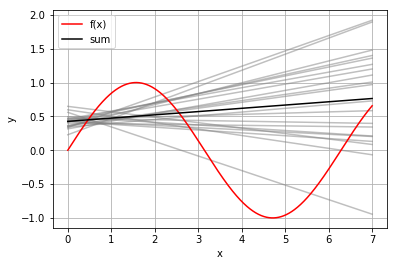

In [9]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
gen_lr_pred = []
for i in range(samples_num):
    x = np.random.exponential(size=sample_size)
    y = f(x) + np.random.uniform(-1, 1, sample_size)
    lr.fit(x[:, np.newaxis], y)
    lr_pred = lr.predict(linspace[:, np.newaxis])
    gen_lr_pred.append(lr_pred)
    plt.plot(linspace, lr_pred, color="gray", alpha=0.5)
plt.plot(linspace, f(linspace), label="f(x)", color="red")
plt.plot(linspace, sum(gen_lr_pred) / samples_num, label="sum", color="black")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend(loc='best')
plt.show()

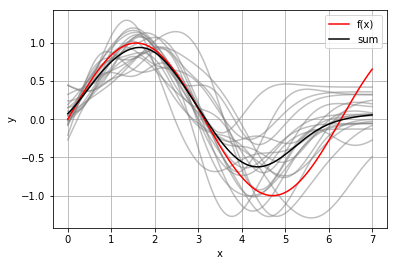

In [10]:
from sklearn.svm import SVR

svm = SVR(kernel='rbf')
gen_svm_pred = []
for i in range(samples_num):
    x = np.random.exponential(size=sample_size)
    y = f(x) + np.random.uniform(-1, 1, sample_size)
    svm.fit(x[:, np.newaxis], y)
    svm_pred = svm.predict(linspace[:, np.newaxis])
    gen_svm_pred.append(svm_pred)
    plt.plot(linspace, svm_pred, color="gray", alpha=0.5)
plt.plot(linspace, f(linspace), label="f(x)", color="red")
plt.plot(linspace, sum(gen_svm_pred) / samples_num, label="sum", color="black")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend(loc='best')
plt.show()

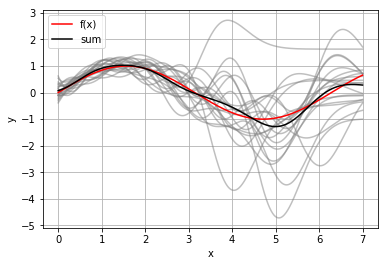

In [18]:
from sklearn.svm import SVR

svm = SVR(C=100, kernel='rbf')
gen_svm_pred = []
for i in range(samples_num):
    x = np.random.exponential(size=sample_size)
    y = f(x) + np.random.uniform(-1, 1, sample_size)
    svm.fit(x[:, np.newaxis], y)
    svm_pred = svm.predict(linspace[:, np.newaxis])
    gen_svm_pred.append(svm_pred)
    plt.plot(linspace, svm_pred, color="gray", alpha=0.5)
plt.plot(linspace, f(linspace), label="f(x)", color="red")
plt.plot(linspace, sum(gen_svm_pred) / samples_num, label="sum", color="black")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend(loc='best')
plt.show()

Из полученных графиков можно сделать вывод, что линейная регрессия слабо приближает истинную зависимость. Это логично, так как исходная функция нелинейна. SVM делает более гладкое приближение. Смещение в SVM близко к нулю. Самое близкое приближение получилось в последнем случае.

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [24]:
import pandas as pd

url1 = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
url2 = "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data"
url3 = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
url4 = "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data"

data1 = pd.read_csv(url1, header = None)
data2 = pd.read_csv(url2, header = None)
data3 = pd.read_csv(url3, header = None)
data4 = pd.read_csv(url4, header = None)

In [26]:
X, Y = [0]*4, [0]*4

In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X[0] = data1.loc[:, data1.columns != 0].apply(le.fit_transform).values
Y[0] = data1.loc[:, data1.columns == 0].apply(le.fit_transform).values.flatten()
X[1] = data2.loc[:, data2.columns != 9].apply(le.fit_transform).values
Y[1] = data2.loc[:, data2.columns == 9].apply(le.fit_transform).values.flatten()
X[2] = data3.loc[:, data3.columns != 6].apply(le.fit_transform).values
Y[2] = np.logical_or(data3[6].values == 'good', data3[6].values == 'vgood')
X[3] = data4.loc[:, data4.columns != 8].apply(le.fit_transform).values
Y[3] = np.logical_or(data4[8].values == 'very_recom',data4[8].values == 'priority',data4[8].values == 'spec_prior')

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer

for i in range(4):
    print(np.mean(cross_val_score(DecisionTreeClassifier(), X[i], Y[i], cv=10, scoring=make_scorer(accuracy_score))))

0.962593066128
0.714883455417
0.940390269981
0.785428883697


__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

На разных данных получается различный результат.

### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [17]:
wines = pd.read_csv('winequality-red.csv', sep=';')

y = wines['quality']
X = wines.drop('quality', axis=1)

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score

for classifier in [RandomForestClassifier(n_estimators=100), BaggingClassifier(n_estimators=100, max_features=0.5),
                  BaggingClassifier(n_estimators=100), DecisionTreeClassifier()]:
    print(cross_val_score(classifier, X, y, cv=3, scoring='accuracy'))

[ 0.52897196  0.57973734  0.58003766]
[ 0.51401869  0.55347092  0.5913371 ]
[ 0.5271028   0.5684803   0.57438795]
[ 0.4635514   0.41651032  0.48022599]


#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [21]:
from sklearn.model_selection import train_test_split

wines = pd.read_csv('winequality-red.csv', sep=';')

y = wines['quality']
X = wines.drop('quality', axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

[]

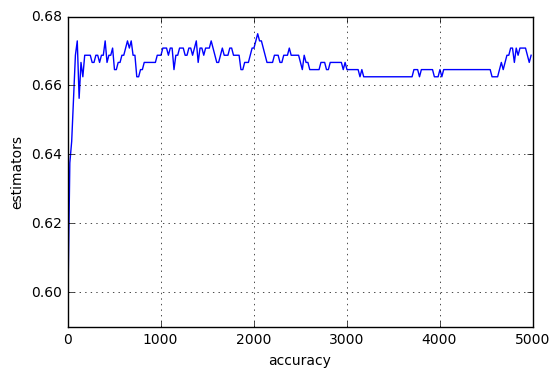

In [26]:
from sklearn.metrics import accuracy_score

cl = RandomForestClassifier(random_state=42, warm_start=True, n_jobs=-1,)
res = []
for i in range(5, 5005, 20):
    cl.set_params(n_estimators = i)
    cl.fit(x_train, y_train)
    res.append(accuracy_score(cl.predict(x_test), y_test))
plt.plot(range(5, 5005, 20), res)
plt.xlabel("accuracy")
plt.ylabel("estimators")
plt.grid()
plt.plot()

Видно что случайный лес практически не переобучается

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

In [39]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### Источники:

Установка:

https://www.tensorflow.org/install/install_windows

https://www.tensorflow.org/get_started/mnist/beginners

In [40]:
print("X_train original shape", x_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


In [41]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print("Training matrix shape", x_train.shape)
print("Testing matrix shape", x_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


In [42]:
from keras.utils import np_utils

nb_classes = 10

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

https://github.com/ksopyla/tensorflow-mnist-convnets

При решении использовала примеры из документации:

https://keras.io/models/sequential/

https://keras.io/getting-started/sequential-model-guide/

https://keras.io/optimizers/

https://keras.io/metrics/

In [44]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, InputLayer

model = Sequential()
# Dense(64) это fully-connected layer с 64 скрытыми нейронами
# В первой строчке специфицируем input, учитывая заданную выше размерность
model.add(InputLayer(input_shape=(784,), activation='relu'))
model.add(Dense(units=100, activation='relu')) # 2 слоя по 100 нейронов
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train)
model.evaluate(x_test, y_test, verbose=0)[1]

Epoch 1/1
60000/60000 [==============================] - 18s 297us/step - loss: 0.1996 - acc: 0.9397


0.96719999999999995

https://keras.io/getting-started/sequential-model-guide/

https://github.com/keras-team/keras/issues/5564

__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

https://keras.io/getting-started/functional-api-guide/

https://github.com/deeplearning4j/deeplearning4j/issues/4219

In [65]:
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train/=255
X_test/=255

number_of_classes = 10

Y_train = np_utils.to_categorical(y_train, number_of_classes)
Y_test = np_utils.to_categorical(y_test, number_of_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train)
model.evaluate(X_test, Y_test, verbose=0)[1]

Epoch 1/1
60000/60000 [==============================] - 306s 5ms/step - loss: 0.1250 - acc: 0.9606


0.98160000000000003

__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 

https://faroit.github.io/keras-docs/1.2.1/getting-started/sequential-model-guide/

In [64]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=1)
model.evaluate(X_test, Y_test, verbose=0)[1]

Epoch 1/1
60000/60000 [==============================] - 319s 5ms/step - loss: 0.1269 - acc: 0.9614


0.98609999999999998

Удалось добиться большего качества.